# About this Notebook

The purpose of this notebook is to study a convolutional network solution. The MLP performs well when the validation/test is on the same flight as the training, however it does not generalize well to other flights. We will therefore try to use a new architecture able to detect more complex pattern in the data : a convolutional network. See previous notebook for more details

# Table of Contents

# Import packages

In [155]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
from tabulate import tabulate
from tqdm.notebook import tqdm_notebook
import random

In [169]:
# Reproducibility
torch.manual_seed(27)
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(False)
random.seed(27)
np.random.seed(27)

# 1 - What is a Convolutional Neural Network

A convolutional neural network (CNN, or ConvNet) is a class of artificial neural network (ANN), most commonly applied to analyze visual imagery. Convolutional neural network are a specialized type of artificial neural networks that use a mathematical operation called convolution in place of general matrix multiplication in at least one of their layers. CNN are often compared to the way the brain achieves vision processing in living organisms.

Typical architecture of a convolutional neural network:

<img src="../data/external/Images/CNN.jpeg" alt="CNN" width="700"/>

A convolutional neural network consits of an input layer, hidden layers and an output layer. In a CNN, the hidden layers include layers that perform convolutions. Typically this includes a layer that performs a dot product of the convolution kernel with the layer's input matrix. This product is usually the [Frobenius inner product](https://en.wikipedia.org/wiki/Frobenius_inner_product), and its activattion function is commonly [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks). As the convolution kernel slides along the input matrix for the layer, the convolution operation generates a feature map, which in turn contributes to the input of the next layer. This is followed by other layers such as pooling layers, fully connected layers, and normalization layers.

<font size='3'><b>Convolutional layers</b></font>

Convolutional layer convolve the input and pass its result to the next layer. This is similar to the response of a neuron in the visual cortex to a specific stimulus. After passing through a convolutional layer, the image becomes abstracted to a feature map, also called an activation map :

<img src="../data/external/Images/2D_Convolution_Animation.gif" alt="CNN" width="300"/>

<font size='3'><b>Pooling layers</b></font>

Pooling layers reduce the dimensions of data by combining the outputs of neuron clusters at one layer into a single neuron in the next layer. Local pooling combines small clusters, tilling sizes such as 2x2 are commonly used. Global pooling acts on all the neurons of the feature map. There are two common types of pooling in popular use :
- Max pooling uses the maximum value of each local cluster of neurons in the feature map
- Average pooling takes the average value of each local cluster of neurons in the feature map

Here is an expemple of Max Pooling :

<img src="../data/external/Images/Max_Pooling_GIFg.gif" alt="CNN" width="300"/>

## Specifity of time-series data for CNN

In our case we have *multivariate* with time series data. This mean that there is more than one observation for each time step. We are trying to create a model able to use a sequence of multiple input series and output one time series dependant on the input time series. The input time series are parallel because each series has observations at the same time steps.

# 2 - Import of Data

In [170]:
df2 = pd.read_hdf('../data/interim/Chall_dataset.h5', key=f'Flt1002')
df3 = pd.read_hdf('../data/interim/Chall_dataset.h5', key=f'Flt1003')
df4 = pd.read_hdf('../data/interim/Chall_dataset.h5', key=f'Flt1004')
df7 = pd.read_hdf('../data/interim/Chall_dataset.h5', key=f'Flt1007')

In [171]:
df2.head()

,TL_comp_mag3_cl,TL_comp_mag5_cl,V_BAT1,V_BAT2,INS_ACC_X,INS_ACC_Y,INS_ACC_Z,CUR_IHTR,PITCH,ROLL,AZIMUTH,LINE,IGRFMAG1
Time [s],,,,,,,,,,,,,
45100.0,-1026.777805,-44.982774,25.827,2.015,-0.109544,-0.389939,9.353474,1.734,9.19,0.19,204.01,1002.01,-297.343
45100.1,-1023.030351,-40.600326,25.826,2.014,-0.157305,-0.441169,9.317263,1.759,9.08,-0.03,203.95,1002.01,-296.223
45100.2,-1021.286230,-34.817623,25.824,2.013,-0.179486,-0.462637,9.348927,1.783,8.96,-0.22,203.91,1002.01,-295.079
45100.3,-1023.965085,-29.347438,25.820,2.010,-0.208515,-0.496153,9.333830,1.796,8.85,-0.39,203.90,1002.01,-293.939
45100.4,-1030.701663,-25.421394,25.815,2.007,-0.252133,-0.507891,9.261835,1.788,8.73,-0.55,203.91,1002.01,-292.821


# 3 - Normalization

In [172]:
df2.describe()

scaling_range = [-1,1]
MinMaxScaler_2 = MinMaxScaler(scaling_range)
MinMaxScaler_3 = MinMaxScaler(scaling_range)
MinMaxScaler_4 = MinMaxScaler(scaling_range)
MinMaxScaler_7 = MinMaxScaler(scaling_range)


df2_scaled = pd.DataFrame()
df3_scaled = pd.DataFrame()
df4_scaled = pd.DataFrame()
df7_scaled = pd.DataFrame()


df2_scaled[df2.drop(columns=['LINE','IGRFMAG1']).columns] = MinMaxScaler_2.fit_transform(df2.drop(columns=['LINE','IGRFMAG1']))
df3_scaled[df3.drop(columns=['LINE','IGRFMAG1']).columns] = MinMaxScaler_3.fit_transform(df3.drop(columns=['LINE','IGRFMAG1']))
df4_scaled[df4.drop(columns=['LINE','IGRFMAG1']).columns] = MinMaxScaler_4.fit_transform(df4.drop(columns=['LINE','IGRFMAG1']))
df7_scaled[df4.drop(columns=['LINE','IGRFMAG1']).columns] = MinMaxScaler_7.fit_transform(df7.drop(columns=['LINE','IGRFMAG1']))


df2_scaled.index = df2.index
df3_scaled.index = df3.index
df4_scaled.index = df4.index
df7_scaled.index = df7.index


df2_scaled[['LINE','IGRFMAG1']] = df2[['LINE','IGRFMAG1']]
df3_scaled[['LINE','IGRFMAG1']] = df3[['LINE','IGRFMAG1']]
df4_scaled[['LINE','IGRFMAG1']] = df4[['LINE','IGRFMAG1']]
df7_scaled[['LINE','IGRFMAG1']] = df7[['LINE','IGRFMAG1']]


df2_scaled.describe()

,TL_comp_mag3_cl,TL_comp_mag5_cl,V_BAT1,V_BAT2,INS_ACC_X,INS_ACC_Y,INS_ACC_Z,CUR_IHTR,PITCH,ROLL,AZIMUTH,LINE,IGRFMAG1
count,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000
mean,0.120479,-0.499555,-0.643363,-0.078342,-0.124208,-0.031765,0.058171,-0.026525,0.202881,-0.090270,0.105508,1152.355312,15.822918
std,0.060556,0.148419,0.223182,0.484986,0.168563,0.163822,0.109107,0.352792,0.232093,0.257489,0.537493,603.633030,263.641503
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,158.000000,-868.652000
25%,0.092208,-0.566069,-0.749049,-0.471795,-0.174118,-0.076751,0.013592,-0.260143,0.078834,-0.167997,-0.246764,1002.030000,-106.787250
50%,0.119767,-0.498298,-0.673004,-0.298462,-0.122392,-0.031005,0.058330,-0.072517,0.188985,-0.101912,0.016722,1002.150000,24.219500
75%,0.149140,-0.444462,-0.596958,0.360000,-0.071264,0.014450,0.103938,0.166514,0.307775,-0.032857,0.608167,1002.200000,120.868500
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3086.000000,2699.331000


# 4 - Input Sequence

In [173]:
def trim_data(data,seq_length):
    # Remove excessive data that cannot be in a full sequence
    if (len(data)%seq_length) != 0:
        data = data[:-(len(data)%seq_length)]
    else:
        pass
        
    return data

In [174]:
class MagNavDataset(Dataset):
    # split can be 'Train', 'Val', 'Test'
    def __init__(self, df, seq_length, split):
        
        self.seq_length = seq_length
        
        # Get list of features
        self.features   = df.drop(columns=['LINE','IGRFMAG1']).columns.to_list()
        
        if split == 'train':
            
            sections = np.delete(np.concatenate([df2_scaled.LINE.unique(),df3_scaled.LINE.unique()]),20)
            mask_train = pd.Series(dtype=bool)
            for line in sections:
                mask  = (df.LINE == line)
                mask_train = mask|mask_train
            
            X_train    = df.loc[mask_train,self.features]
            y_train    = df.loc[mask_train,'IGRFMAG1']
            
            self.X = trim_data(torch.tensor(X_train.to_numpy(),dtype=torch.float32),seq_length)
            self.y = trim_data(torch.tensor(np.reshape(y_train.to_numpy(),[-1,1]),dtype=torch.float32),seq_length)
            
        elif split == 'val':
            
            mask_val   = (df.LINE == 1002.14)
            
            X_val      = df.loc[mask_val,self.features]
            y_val      = df.loc[mask_val,'IGRFMAG1']
            
            self.X = trim_data(torch.tensor(X_val.to_numpy(),dtype=torch.float32),seq_length)
            self.y = trim_data(torch.tensor(np.reshape(y_val.to_numpy(),[-1,1]),dtype=torch.float32),seq_length)
            
        elif split == 'test':
            
            mask_test = pd.Series(dtype=bool)
            for line in df7_scaled.LINE.unique():
                mask  = (df.LINE == line)
                mask_test = mask|mask_test
            
            X_test     = df.loc[mask_test,self.features]
            y_test     = df.loc[mask_test,'IGRFMAG1']
            
            self.X = trim_data(torch.tensor(X_test.to_numpy(),dtype=torch.float32),seq_length)
            self.y = trim_data(torch.tensor(np.reshape(y_test.to_numpy(),[-1,1]),dtype=torch.float32),seq_length)
        
    def __getitem__(self, index):
        X = self.X[index:(index+self.seq_length),:]
        y = self.y[index+self.seq_length-1]
        return X, y
    
    def __len__(self):
        return len(self.X)-self.seq_length

In [175]:
df_concat = pd.concat([df2,df3,df4,df7],ignore_index=True,axis=0)

seq_length = 20

train = MagNavDataset(df_concat,seq_length=seq_length,split='train')
val   = MagNavDataset(df_concat,seq_length=seq_length,split='val')
test  = MagNavDataset(df_concat,seq_length=seq_length,split='test')

In [176]:
BATCH_SIZE = 32

train_loader  = DataLoader(train,
                           batch_size=BATCH_SIZE,
                           shuffle=True,
                           num_workers=0,
                           pin_memory=False)

val_loader    = DataLoader(val,
                           batch_size=BATCH_SIZE,
                           shuffle=False,
                           num_workers=0,
                           pin_memory=False)

test_loader    = DataLoader(test,
                           batch_size=BATCH_SIZE,
                           shuffle=False,
                           num_workers=0,
                           pin_memory=False)

# 5 - Model

Training is done in terminal for better performance.

In [177]:
def count_parameters(model): # a rajouter dans magnav.py
    
    total_params = 0
    table = np.array([["Modules","Parameters"]])

    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table = np.concatenate((table,[[name,params]]),axis=0)
        total_params += params
    table = np.concatenate((table,[["",""],["Total Trainable Params",total_params]]),axis=0)
    print(tabulate(table,headers='firstrow',tablefmt="pipe",stralign='right'))

In [178]:
class CNN(torch.nn.Module):
    
    def forward(self, x):
        logits = self.architecture(x)
        return logits

In [179]:
model = torch.load('../models/CNN_runs/CNN_e40_b32_s20_220617_1041/CNN_e40_b32_s20.pt')
count_parameters(model)

|                Modules |   Parameters |
|-----------------------:|-------------:|
|  architecture.0.weight |         6400 |
|    architecture.0.bias |           64 |
|  architecture.3.weight |        24576 |
|    architecture.3.bias |          128 |
|  architecture.7.weight |        49152 |
|    architecture.7.bias |          128 |
|  architecture.9.weight |         8192 |
|    architecture.9.bias |           64 |
| architecture.11.weight |           64 |
|   architecture.11.bias |            1 |
|                        |              |
| Total Trainable Params |        88769 |


In [180]:
preds = []
device = 'cuda:0'
for batch_index, (inputs, labels) in enumerate(test_loader):
    model.eval()
    with torch.no_grad():
        preds.append(model(inputs.to(device)).cpu())
preds = np.concatenate(preds)

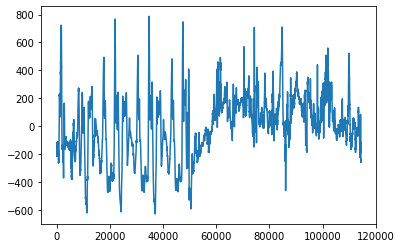

In [181]:
plt.plot(preds)

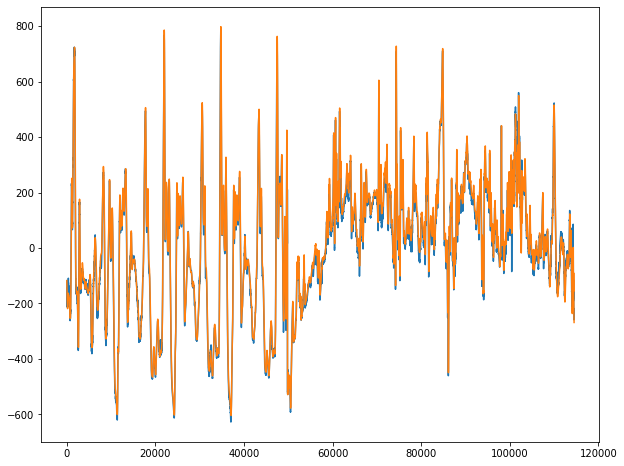

In [182]:
fig, ax = plt.subplots(figsize=[10,8])
plt.plot(preds)
plt.plot(test.y)
plt.show()

In [183]:
magnav.rmse(preds,test.y[20:],False)

18.191935

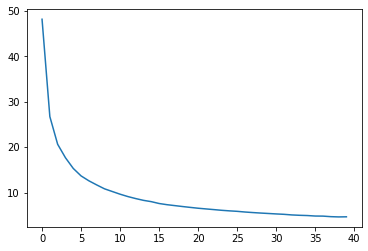

In [184]:
train_loss = []

my_file = open('../models/CNN_runs/CNN_e40_b32_s20_220617_1041/train_loss.txt','r')
content = my_file.readlines()
content = [float(x.rstrip()) for x in content]
plt.plot(content)

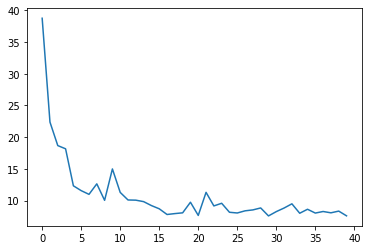

In [185]:
val_loss = []

my_file = open('../models/CNN_runs/CNN_e40_b32_s20_220617_1041/val_loss.txt','r')
content = my_file.readlines()
content = [float(x.rstrip()) for x in content]
plt.plot(content)